In [1]:
import pandas as pd
import os
import sys


#  manually go up to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

#load Datasets
form_1_path = os.path.join('..','Database', 'processed','form_1_cleaned_v2.csv')
form_2_path = os.path.join('..','Database', 'processed','form_2_cleaned_v2.csv')

df_form_1 = pd.read_csv(form_1_path)

df_form_2 = pd.read_csv(form_2_path)

#select followup period
df_form_2_followup = df_form_2[df_form_2['FollowUpPeriodGroup'] == 5]

#prepare labels
df_form_2_followup['drs_outcome'] = pd.cut(
    df_form_2_followup['CombinedDRSF'], 
    bins=[0,21,30], 
    right=True, 
    labels=[0,1]
)

df_form_2_labels = df_form_2_followup[['Mod1Id', 'drs_outcome']]

#remove NA
df_form_2_labels = df_form_2_labels.dropna(subset=['Mod1Id', 'drs_outcome'])

C:\Users\benol\AppData\Local\Temp\ipykernel_31532\1911664526.py:15: DtypeWarning: Columns (371,372,373) have mixed types. Specify dtype option on import or set low_memory=False.
  df_form_1 = pd.read_csv(form_1_path)
C:\Users\benol\AppData\Local\Temp\ipykernel_31532\1911664526.py:17: DtypeWarning: Columns (62,63,248,251,252) have mixed types. Specify dtype option on import or set low_memory=False.
  df_form_2 = pd.read_csv(form_2_path)
C:\Users\benol\AppData\Local\Temp\ipykernel_31532\1911664526.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_form_2_followup['drs_outcome'] = pd.cut(


In [2]:
df_form_2_followup['drs_outcome'].value_counts()

drs_outcome
0    7030
1     888
Name: count, dtype: int64

In [3]:
#merge labels on training data
data = pd.merge(
    df_form_1,
    df_form_2_labels,
    on='Mod1Id',
    how='inner'
                )

#check merge, how many rows were dropped?
print(df_form_1.shape)
print(data.shape)

#subset
X = data.drop(columns=['Mod1Id', 'drs_outcome'])
y = data['drs_outcome']

(19560, 375)
(7914, 376)


In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from src.data_pipeline import preprocess_df
import json


#preprocessing pipeline (can probably move this but dont want to break atm)
ordinal_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

dict_path = os.path.join('..','Database', 'processed', 'form_1_column_dict.json')

with open(dict_path, 'r') as file:
    form_1_column_dict = json.load(file)

ordinal_col = form_1_column_dict['ordinal_col']
nominal_col = form_1_column_dict['nominal_col']
continuous_col = form_1_column_dict['continuous_col']
continuous_col.remove('Mod1Id')

#preprocess
X = preprocess_df(
    X,
    ordinal_col,
    nominal_col,
    continuous_col,
    ordinal_pipeline,
    categorical_pipeline,
    numerical_pipeline,
    threshold=0.8
    )

#check feature expansion
print(X.shape)

c:\Users\benol\Documents\GitHub\PREDDICT-Spaulding\src\data_pipeline.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


(7914, 3214)


In [5]:
from src.training import learning_curve_auc, learning_curve_pr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier


#this takes nearly 20 mins

#set up static reference
X_static = X[['num__DRSd']].values #double brackets to keep it 2-d
y_static = y.values

#training data for full dataset
X_full = X.values
y_full = y.values

#define sample sizes (10, 20, 30% etc)
sample_sizes = np.linspace(0.1, 0.99, 10)

model = SGDClassifier(
                loss='log_loss',  #logistic regression
                penalty='l2',
                alpha=0.001,       #regularization strength (like 1/C)
                max_iter=1000,
                class_weight='balanced',
                random_state=42
                )

#calculate auc and std for every sample size
ap_means_static, ap_stds_static, pr_curves_static = learning_curve_pr(X_static, y_static, sample_sizes, model, n_splits=5)
ap_means_full, ap_stds_full, pr_curves_full = learning_curve_pr(X_full, y_full, sample_sizes, model, n_splits=5)

Training Data Samples: 100%|██████████| 10/10 [07:09<00:00, 42.96s/it]


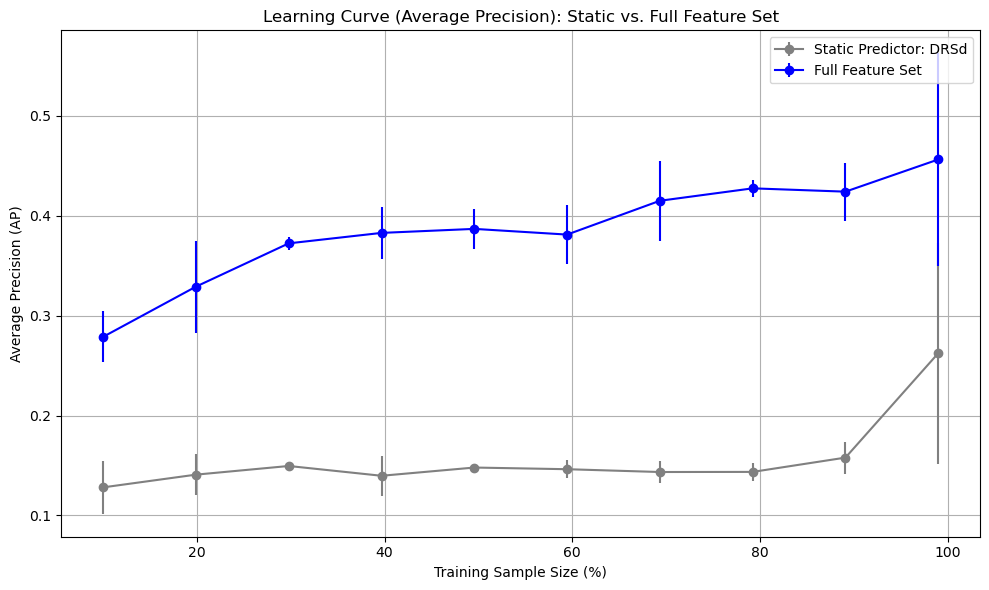

In [6]:
plt.figure(figsize=(10, 6))

# Replace variable names to match AP results
plt.errorbar(sample_sizes * 100, ap_means_static, yerr=ap_stds_static, label="Static Predictor: DRSd", fmt='-o', color='gray')
plt.errorbar(sample_sizes * 100, ap_means_full, yerr=ap_stds_full, label="Full Feature Set", fmt='-o', color='blue')

# Update axis labels
plt.xlabel("Training Sample Size (%)")
plt.ylabel("Average Precision (AP)")
plt.title("Learning Curve (Average Precision): Static vs. Full Feature Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

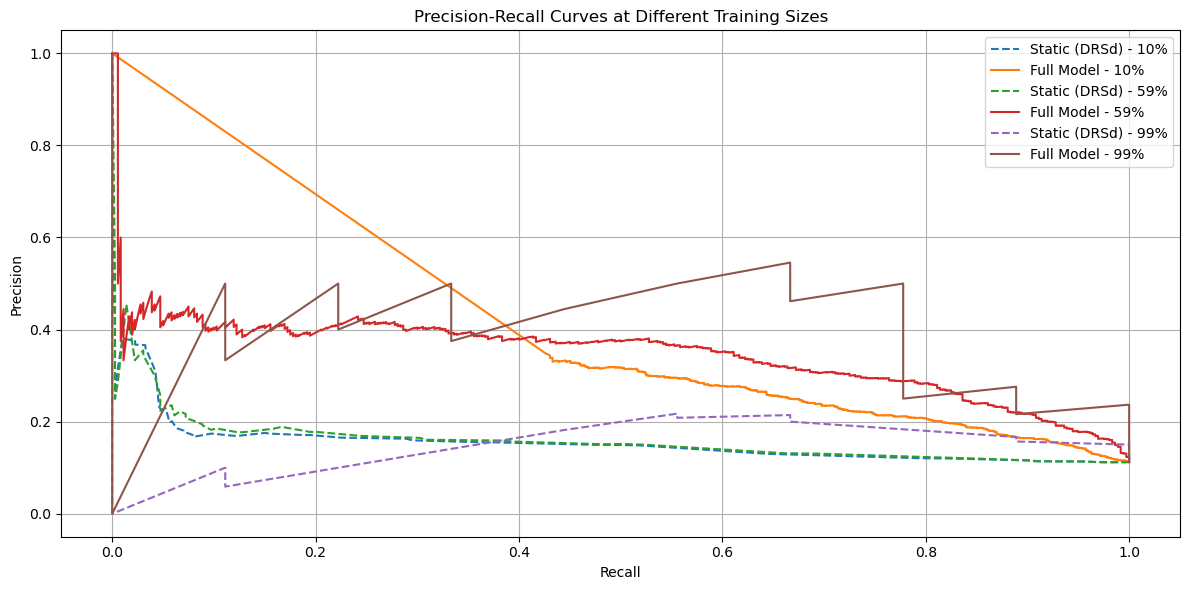

In [7]:
# Select training size indices to visualize (e.g., first, middle, last)
plot_indices = [0, len(sample_sizes) // 2, -1]

plt.figure(figsize=(12, 6))

for idx in plot_indices:
    precision_s, recall_s = pr_curves_static[idx]
    precision_f, recall_f = pr_curves_full[idx]
    
    size_percent = int(sample_sizes[idx] * 100)
    
    # Static predictor PR curve
    plt.plot(recall_s, precision_s, linestyle='--', label=f"Static (DRSd) - {size_percent}%")
    
    # Full feature PR curve
    plt.plot(recall_f, precision_f, linestyle='-', label=f"Full Model - {size_percent}%")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves at Different Training Sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
#check for label leakage in continuous features
correlations = data[continuous_col + ['drs_outcome']].corr()['drs_outcome'].sort_values(ascending=False)
print(correlations.head(20))

drs_outcome            1.000000
AGENoPHI               0.300085
FluencyInt             0.300085
GCSTot                 0.194387
GCS                    0.184932
YearsinUSF             0.146283
ALCWeek                0.114780
INJYEAR                0.100460
DRSd                   0.090718
DRSdHigh               0.090306
DRSdLow                0.090137
RTSBP                  0.073792
YoungestAgeLOC         0.072725
AlcMonth               0.042479
DAYStoACUTEadm         0.042235
ICDCount               0.038361
ALC5Drinks             0.037422
FIMCOGA                0.027598
cntModSevAfterIndex    0.014563
YoungestAgeTBI         0.009563
Name: drs_outcome, dtype: float64


In [9]:
#check for label leakage in categorical features
data['drs_outcome'] = data['drs_outcome'].astype(int)  # or float


for col in ordinal_col + nominal_col:
    group_key = data[col].astype(str)
    grouped = data.groupby(group_key)['drs_outcome'].agg(['mean', 'count'])
    suspicious = grouped[((grouped['mean'] < 0.03) | (grouped['mean'] > 0.97)) & (grouped['count'] > 1000)]
    if not suspicious.empty:
        print(f"\nPotential leakage in '{col}':")
        print(suspicious.sort_values(by='mean', ascending=False))


Potential leakage in 'RaceBlkF':
              mean  count
RaceBlkF                 
1.0       0.029433   1359
